**(Dynamic) Thompson Sampling, as described in Gupta et al. - 2011 - Thompson sampling for dynamic multi-armed bandits**

> Thompson sampling is a probabilistic approach to solve the Multi-Armed Bandit. This paper modifies the original algorithm to make it handle distribution changes during the execution

The Thompson Sampling in this paper considers that each arm is a Bernoulli trial, having the output set ${0, 1}$, with $\theta^k$ denoting the probability of success for arm $k$.

The probability distribution of successes $S$ obtained in $n^k$ trials is a Binomial distribution:

$$p(S = s|\theta^k) = \binom{n^k}{s} (1-\theta^k)^{n-s}(\theta^k)^s.$$

The Beta distribution is a conjugate prior (is of the same probability distribution family as the prior probability, which is the Binomial distribution), parameterized by $\alpha_0$ and $\beta_0$:

$$p(\widehat{\theta}^k; \alpha_0, \beta_0) = \frac{x^{\alpha_0-1}(1-x)^{\beta_0-1}}{B(\alpha_0, \beta_0)},$$

with $B$ being a binonial distribution.

> We use conjugate prior to derive a closed-form expression for the posterior distribution, usually easier to interpret, manipulate and update. In Bayesian statistics, we adjust the hyperparameters of the posterior distribution to optimize the likelihood with the prior distribution.

The **original Thompson sampling** updates $\alpha_n$ and $\beta_n$ for the $n$-th trial, with reward $r_n$ as:

$$\alpha^k_ n = \alpha^k_{n-1} + r_n,$$
$$\beta^k_ n = \beta^k_{n-1} + (1-r_n).$$

The proposed method extends the original algorithm by inserting a new update rule based on an hyperparameter $C$. $C$ is a threshold that provides exponential weighting of the outcomes of the trials, making more recent rewards getting more weight. This way, if prior distributions change during the execution, the learned posterior distributions would respond to it.

We update $\alpha_n$ and $\beta_n$ conditionally based on $C$:

If $\alpha_{n-1}+\beta_{n-1}<C$, we use the original Thompson Sampling. Otherwise, we update

$$\alpha^k_ n = (\alpha^k_{n-1} + r_n)\frac{C}{C+1},$$
$$\beta^k_ n = (\beta^k_{n-1} + (1-r_n))\frac{C}{C+1}.$$

> The paper suggest initializing all $\alpha$ and $\beta$ with the value $2$ for all arms.

The remaining of the paper performs an sensitivity analysis and some experiments to check how well the Dynamic Thompson Sampling performs.

> In our work, the mutations would be the arms, and this update would be used during the evolution to adjust the mutation probabilities.

> Brush originally sample the mutations using an uniform distribution. This algorithm learns hyperparameters to Beta distributions. Somehow we need to convert them to have a transparent implementation to the user.

In [1]:
import numpy as np

class D_TS:
    def __init__(self, num_bandits, C=100):
        self.num_bandits = num_bandits

        # Store learner status when the update function is called
        self.pull_history = {
            c:[] for c in ['t', 'arm idx', 'reward', 'update'] + 
                          [f'alpha {i}' for i in range(num_bandits)] + 
                          [f'beta {i}' for i in range(num_bandits)]} 

        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self._alphas = 2*np.ones(num_bandits) # Paper suggests starting with 2's
        self._betas  = 2*np.ones(num_bandits)
        self.C       = C # how to define this value???

    @property
    def probabilities(self):
        # How to transform our Beta distributions into node probabilities?
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses the learned distributions to randomly choose an arm to pull. 
        
        Returns the index of the arm that was choosen based on the Beta
        probabilities of previous successes and fails.
        """
        
        # probability estimates from the beta distribution
        thetas = np.random.beta(self._alphas, self._betas)
        
        arm_idx = np.argmax(thetas)
        
        return arm_idx
    
    def update(self, arm_idx, reward):
        self.pull_history['t'].append( len(self.pull_history['t']) )
        self.pull_history['arm idx'].append( arm_idx )
        self.pull_history['reward'].append( reward )
        
        for i in range(self.num_bandits):
            self.pull_history[f'alpha {i}'].append( self._alphas[i] )
            self.pull_history[f'beta {i}'].append( self._betas[i] )

        if self._alphas[arm_idx] + self._betas[arm_idx] < self.C:
            # This is the pure thompson scheme
            self._alphas[arm_idx] = self._alphas[arm_idx]+reward
            self._betas[arm_idx]  = self._betas[arm_idx]+(1-reward)

            self.pull_history['update'].append( 0 )
        else:
            # This is the dynamic adjust
            self._alphas[arm_idx] = (self._alphas[arm_idx]+reward)*(self.C/(self.C+1))
            self._betas[arm_idx]  = (self._betas[arm_idx]+(1-reward))*(self.C/(self.C+1))

            self.pull_history['update'].append( 1 )

        return self

In [2]:
# Sanity checks
import pandas as pd

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1 if result > self.reward_prob[arm_idx] else 0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_TS(4)
    for i in range(10000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    learner_log = pd.DataFrame(learner.pull_history).set_index('t')

    total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
    total_pulls   = learner_log['arm idx'].value_counts().to_dict()

    print("cum. reward for each arm    : ", total_rewards)
    print("number of pulls for each arm: ", total_pulls)
    print(f"(it was expected: {expec})")

------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 448, 1: 366, 2: 427, 3: 303}
number of pulls for each arm:  {0: 2821, 2: 2682, 1: 2461, 3: 2036}
(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 8406, 1: 7, 2: 4, 3: 0}
number of pulls for each arm:  {0: 9969, 1: 16, 2: 10, 3: 5}
(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 25, 1: 5012, 2: 11, 3: 3361}
number of pulls for each arm:  {1: 5919, 3: 4022, 0: 39, 2: 20}
(it was expected: 2nd approx 4th > 1st > 3rd)


In [3]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # mutations optimized by the learner. Learner arms correspond to
        # these mutations in the order they appear here
        self.mutations_ = ['point', 'insert', 'delete', 'toggle_weight']

        # Whether the learner should update after each mutation, or if it should
        # update only after a certain number of evaluations.
        # Otherwise, it will
        # store all rewards in gen_rewards_ (which is reseted at the beggining
        # of every generation) and do a batch of updates only after finishing
        # mutating the solutions.
        self.batch_size_    = self.pop_size*2 #
        self.batch_rewards_ = []

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        
        params = self.get_params()
        
        ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
                                    or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        if ignore_this_time:
            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        else:
            mutation_idx = self.learner_.choose_arm()

            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        # ind1.prg.mutate is a convenient interface that uses the current search 
        # space to sample mutations
        offspring = creator.Individual(ind1.prg.mutate())

        offspring.fitness.values = self.toolbox_.evaluate(offspring)
        
        # We compare fitnesses using the deap overloaded operators
        # from the docs: When comparing fitness values that are **minimized**,
        # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
        # (this means that this comparison should work agnostic of min/max problems,
        # or even a single-objective or multi-objective problem)
        reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
        
        if not ignore_this_time:
            self.batch_rewards_.append( (mutation_idx, reward) )

        if len(self.batch_rewards_) > self.batch_size_:
            for (mutation_idx, reward) in self.batch_rewards_:
                self.learner_.update(mutation_idx, reward)
            self.batch_rewards_ = []
        
        return offspring
    
    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_TS(4, C=self.pop_size*3)

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.logbook_ = logbook
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
        )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

In [4]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # data = pd.read_csv('../../docs/examples/datasets/d_enc.csv')
    # X = data.drop(columns='label')
    # y = data['label']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est     = BrushRegressor(**kwargs).fit(X,y)
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
            
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 


Brush version  Original                                                       
metric            score                               best model size depth   
run 0          0.350809               If(x1>0.91,Abs(1.61),0.38)    4     2  \
run 1          0.325058                            Cos(-1.72*x2)    2     1   
run 2          0.325058                             Cos(1.72*x2)    2     1   
run 3          0.325058                            Cos(-1.72*x2)    2     1   
run 4          0.325058                            Cos(-1.72*x2)    2     1   
run 5          0.325058                            Cos(-1.72*x2)    2     1   
run 6          0.198205                             Abs(0.74*x1)    2     1   
run 7          0.325058                            Cos(-1.72*x2)    2     1   
run 8          0.113124                         Sqrtabs(0.40*x1)    2     1   
run 9          0.325058                            Cos(-1.72*x2)    2     1   
run 10         0.289662                  1.54*Logistic(-1.98*x2)    2     1   
run 11         0.325058                             Cos(1.72*x2)    2     1   
run 12         0.314972                       0.51*Acos(1.10*x2)    2     1   
run 13         0.325058                            Cos(-1.72*x2)    2     1   
run 14         0.325058                             Cos(1.72*x2)    2     1   
run 15         0.325058                             Cos(1.72*x2)    2     1   
run 16         0.028410                        Logistic(0.57*x1)    2     1   
run 17         0.325058                            Cos(-1.72*x2)    2     1   
run 18         0.325058                            Cos(-1.72*x2)    2     1   
run 19         0.325058                             Cos(1.72*x2)    2     1   
run 20         0.325058                             Cos(1.72*x2)    2     1   
run 21         0.325058                             Cos(1.72*x2)    2     1   
run 22         0.325058                             Cos(1.72*x2)    2     1   
run 23         0.325058                            Cos(-1.72*x2)    2     1   
run 24         0.325058                            Cos(-1.72*x2)    2     1   
run 25         0.325058                            Cos(-1.72*x2)    2     1   
run 26         0.275650                          Logabs(2.31*x1)    2     1   
run 27         0.551982  1.01*Logistic(-130.89*Logabs(-2.14*x2))    3     2   
run 28         0.325058                             Cos(1.72*x2)    2     1   
run 29         0.325058                            Cos(-1.72*x2)    2     1   

Brush version  Modified                                                      
metric            score                                         best model   
run 0          0.326358                                  1.04*Cos(1.73*x2)  \
run 1          0.326358                                  1.04*Cos(1.73*x2)   
run 2          0.363372          If(x1>0.91,1.26*Square(1.20*x1),-0.52*x1)   
run 3          0.386766      Mean(1.30*Cos(3.86*x2),-1.40*x2,3.38,0.21*x1)   
run 4          0.508543                 Median(2.01,-1.94*x2,1.27*x1,1.27)   
run 5          0.421938  Mean(2.23*Cos(Max(1.63*x2,-16.06*x2,x2,x2)),-0...   
run 6          0.480289             If(x1>0.91,1.61,0.81*Logabs(-2.30*x1))   
run 7          0.367344     0.95*Cos(Max(1.75*x2,Acos(1.25*Cos(1.52*x2))))   
run 8          0.292958                                    0.91*Square(x1)   
run 9          0.363372                          If(x1>0.91,1.61,-0.52*x1)   
run 10         0.550445         Logistic(Add(18.67*Cos(3.17*x2),-3.09*x1))   
run 11         0.418151            Square(Sum(1.20*Cos(1.82*x2),-0.37*x2))   
run 12         0.356233                     1.02*Cos(Max(1.77*x2,0.55,x2))   
run 13         0.964814           1.65*Cos(Mean(2.12*x2,1.39*x2,-3.00*x1))   
run 14         0.363372                          If(x1>0.91,1.61,-0.52*x1)   
run 15         0.999862         Square(Mean(1.99*x1,2.03*x1,3.96*x2,0.02))   
run 16         0.958755     1.63*Cos(Mean(2.82*x2,2.08*x2,-0.15,-4.

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          30.000000  30.000000  30.000000  30.000000  30.000000  \
mean            0.309137   2.100000   1.066667   0.447554   3.900000   
std             0.082495   0.402578   0.253708   0.192888   1.626293   
min             0.028410   2.000000   1.000000   0.292958   2.000000   
25%             0.325058   2.000000   1.000000   0.332471   2.250000   
50%             0.325058   2.000000   1.000000   0.365332   4.000000   
75%             0.325058   2.000000   1.000000   0.473324   5.000000   
max             0.551982   4.000000   2.000000   0.999862   8.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          30.000000            30.000000             30.000000  \
mean            1.733333          5247.466667           2201.933333   
std             0.827682           810.890091            454.865871   
min             1.000000          3751.000000           1417.000000   
25%             1.000000          4787.000000           1877.500000   
50%             2.000000          5243.500000           2217.000000   
75%             2.000000          5705.000000           2416.750000   
max             4.000000          7325.000000           3227.000000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                     30.000000                    30.000000  
mean                    1373.066667                   825.533333  
std                      425.113529                   318.965000  
min                      448.000000                   153.000000  
25%                     1113.750000                   697.250000  
50%                     1319.000000                   846.500000  
75%                     1625.500000                   994.250000  
max                     2216.000000                  1370.000000

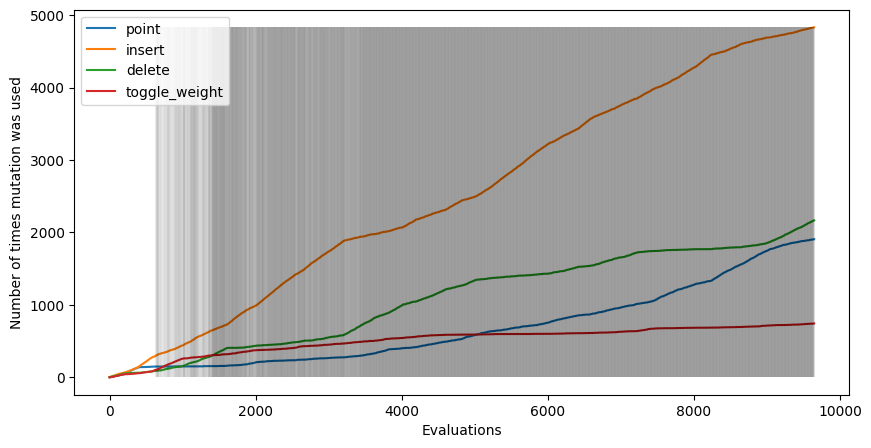

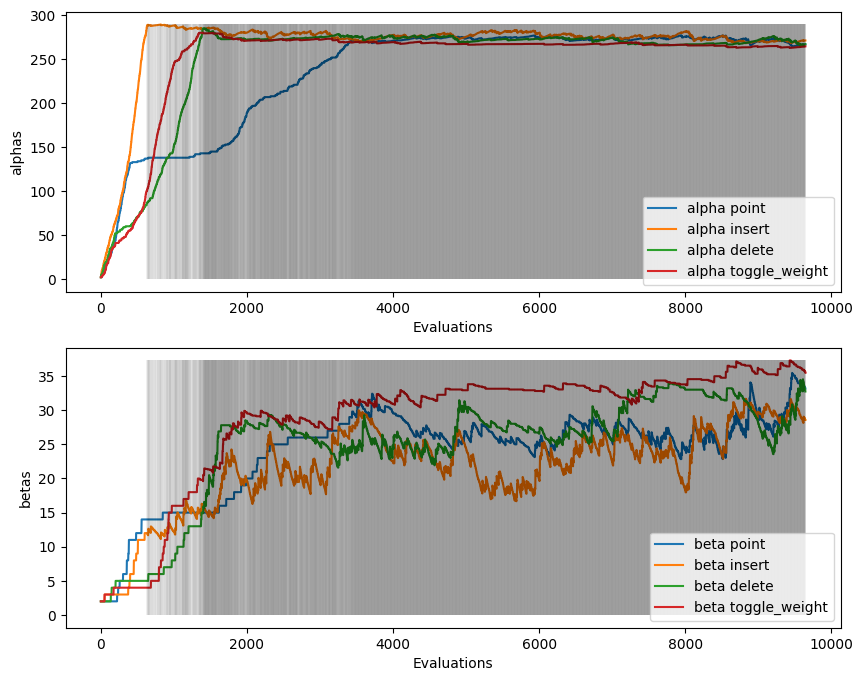

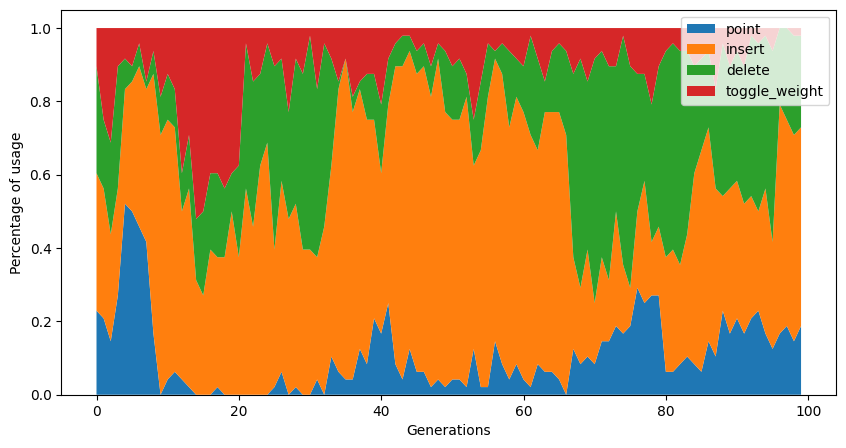

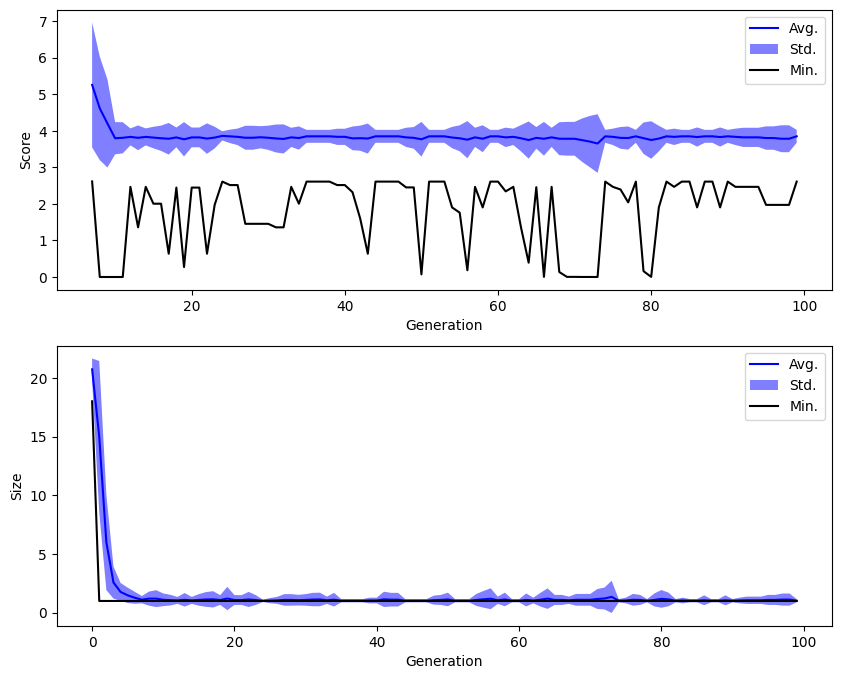

In [5]:
def generate_plots():
    !pip install matplotlib > /dev/null
    import matplotlib.pyplot as plt
    
    # plot the cumulative number of pulls (for evaluations, not generations) ---
    data = np.zeros( (learner_log.shape[0]+1, 4) )
    for i, row in learner_log.iterrows():
        data[i+1, :] = data[i]
        data[i+1, row['arm idx'].astype(int)] += 1

    plt.figure(figsize=(10, 5))

    plt.plot(data, label=est_mab.mutations_)
    plt.xlabel("Evaluations")
    plt.ylabel("Number of times mutation was used")

    # multiple lines all full height showing when D-TS used the dynamic update rule
    plt.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
               ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    for i, col in enumerate(['alpha', 'beta']):
        columns = learner_log.columns[learner_log.columns.str.startswith(f'{col} ')]
        labels  = [columns[i].replace(str(i), est_mab.mutations_[i]) for i in range(4)] 
        data    = learner_log.loc[:, columns]

        axs[i].plot(data, label=labels)
        axs[i].set_xlabel("Evaluations")
        axs[i].set_ylabel(f"{col}s")
        axs[i].legend()

        # multiple lines all full height showing when D-TS used the dynamic update rule
        axs[i].vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
                ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.show()

    # Approximating the percentage of usage for each generation ----------------
    data = np.zeros( (kwargs['max_gen'], 4) )
    for g in range(kwargs['max_gen']):
        idx_start = g*(learner_log.shape[0]%kwargs['max_gen'])
        idx_end   = (g+1)*(learner_log.shape[0]%kwargs['max_gen'])

        df_in_range = learner_log.iloc[idx_start:idx_end]
        g_data = df_in_range['arm idx'].value_counts(normalize=True).to_dict()
        for k, v in g_data.items():
            data[g, k] = v

    plt.figure(figsize=(10, 5))

    #plt.plot(data, label=est_mab.mutations_)
    plt.stackplot(range(kwargs['max_gen']), data.T, labels=est_mab.mutations_)
    plt.xlabel("Generations")
    plt.ylabel("Percentage of usage")

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    logbook = pd.DataFrame(columns=['gen', 'evals', 'ave m1', 'ave m2',
                                    'std m1', 'std m2', 'min m1', 'min m2'])
    for item in est_mab.logbook_:
        # I'll store the calculate
        logbook.loc[item['gen']] = (
            item['gen'], item['evals'], *item['ave'], *item['std'], *item['min']
        )

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    x = logbook['gen']
    for i, metric in enumerate(['m1', 'm2']):
        y     = logbook[f'ave {metric}']
        y_err = logbook[f'std {metric}']
        y_min = logbook[f'min {metric}']

        axs[i].plot(x, y, 'b', label='Avg.')
        axs[i].fill_between(x, y-y_err, y+y_err, fc='b', alpha=0.5, label="Std.")
        axs[i].plot(x, y_min, 'k', label='Min.')

        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Score" if metric=='m1' else "Size")
        axs[i].legend()

    plt.show()

generate_plots()

## Classification problem

In [6]:
if __name__ == '__main__':
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    # X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est = BrushClassifier(**kwargs).fit(X,y)
            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
            
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 


Brush version Original                                                      
metric           score                                         best model   
run 0             0.76  Logistic(Add(Min(Sinh(-0.00*Total),AIDS,1.00),...  \
run 1             0.82  Logistic(2.21*Cos(0.98*Sub(2.26*Sin(Median(1.9...   
run 2             0.76            Logistic(Sin(Median(1.00*Total,-4.24)))   
run 3             0.78   Logistic(Cos(1.00*Mean(Total,0.64*AIDS,606.78)))   
run 4             0.76  Logistic(Div(Sum(10407.20,162.04*AIDS,-0.12*To...   
run 5             0.82  Logistic(Cos(Median(1.00*Div(1.00*Total,Median...   
run 6             0.78             Sqrt(Median(-0.93*Total,1313.06*AIDS))   
run 7             0.84  Abs(Sin(Prod(Square(Atan(Median(0.00*AIDS,1.00...   
run 8             0.86  Abs(Median(Square(Min(Median(Floor(-0.00*Total...   
run 9             0.80  Logistic(Mean(Median(Sqrtabs(-0.13),Square(Tot...   
run 10            0.76               Sum(-0.00*Total,Logistic(0.00*AIDS))   
run 11            0.68                     Sum(0.40,-0.25*AIDS,0.25*AIDS)   
run 12            0.82  Median(Median(-0.31*AIDS,-0.00*Total,4.42,0.02...   
run 13            0.78            Tanh(Log1p(Div(49.93*AIDS,0.05*Total)))   
run 14            0.78  Square(Tanh(Logistic(Div(1109.21*AIDS,0.40*Tot...   
run 15            0.90  Logistic(Prod(Sum(-0.00*AIDS,Median(Tan(Sum(-0...   
run 16            0.78   Atan(Sqrt(Atan(Div(-1441.21*AIDS,-3.24*Total))))   
run 17            0.70  Logistic(Cos(Sum(1.00*AIDS,1.13,1.00*Total,1.1...   
run 18            0.82  Abs(Max(Sum(Tanh(0.01*AIDS),0.00*AIDS,Atan(-0....   
run 19            0.92  Median(Sub(Cos(Mean(Median(Sum(0.70*Total,-5.3...   
run 20            0.84  Min(Mean(0.00*AIDS,Cos(Sum(Min(Logabs(Log1p(-0...   
run 21            0.68  Logistic(Sin(If(AIDS>68817.00,If(AIDS>0.00,7.4...   
run 22            0.84  Sqrt(Sin(Sum(1.83,Median(Max(Floor(0.00*AIDS),...   
run 23            0.80  Add(Abs(Mean(Sin(0.00*AIDS),Asin(-0.00*Total),...   
run 24            0.82                Logistic(Cos(Ceil(Abs(0.48*AIDS))))   
run 25            0.68                          Mean(0.50,0.00*AIDS,0.69)   
run 26            0.74        Mean(Atan(0.05*AIDS),-0.00*Total,0.00*AIDS)   
run 27            0.78      Logistic(Exp(Mean(1024.34*AIDS,-0.74*Total)))   
run 28            0.78                Sqrt(Sub(13510.11*AIDS,9.40*Total))   
run 29            0.88  Sqrtabs(Median(0.00*AIDS,Atan(Min(Sin(Sqrtabs(...   

Brush version            Modified   
metric        size depth    score   
run 0            8     4     0.82  \
run 1           13     5     0.78   
run 2            5     3     0.74   
run 3            6     3     0.74   
run 4            7     3     0.84   
run 5           14     8     0.78   
run 6            4     2     0.68   
run 7           16     8     0.68   
run 8           16     8     0.68   
run 9           15     4     0.74   
run 10           4     2     0.72   
run 11           4     1     0.74   
run 12          11     2     0.76   
run 13           5     3     0.78   
run 14           6     4     0.68   
run 15          18     6     0.78   
run 16           6     4     0.78   
run 17           7     3     0.68   
run 18          10     4     0.68   
run 19          20     6     0.74   
run 20          19     7     0.72   
run 21           8     4     0.78   
run 22          15     6     0.78   
run 23           9     4     0.68   
run 24           5     4     0.88   
run 25           4     1     0.78   
run 26           5     2     0.68   
run 27           5     3     0.74   
run 28           4     2     0.76   
run 29          15     7     0.78   

Brush version                                                                 
metric                                                best model size depth   
run 0          Log1p(Min(Median(Logistic(4.97*Sin(Median(1.00...   15     7  \
run 1          Mean(Max(Cos(18.50*Mean(Sin(1.00*AIDS),0.52)),...   11     5   
run 2                Mean(Atan(0.0

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          30.000000  30.000000  30.000000  30.000000  30.000000  \
mean            0.792000   9.466667   4.100000   0.746667   6.600000   
std             0.060252   5.217565   2.056948   0.052347   4.399059   
min             0.680000   4.000000   1.000000   0.680000   2.000000   
25%             0.760000   5.000000   3.000000   0.690000   2.500000   
50%             0.780000   7.500000   4.000000   0.740000   5.500000   
75%             0.820000  14.750000   5.750000   0.780000   8.750000   
max             0.920000  20.000000   8.000000   0.880000  20.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          30.000000            30.000000             30.000000  \
mean            3.133333          5435.100000           2105.333333   
std             1.925032          1062.467471            599.846724   
min             1.000000          3308.000000           1044.000000   
25%             1.250000          4632.500000           1751.750000   
50%             3.000000          5677.000000           2151.500000   
75%             4.000000          6093.750000           2411.500000   
max             7.000000          7535.000000           3895.000000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                      30.00000                    30.000000  
mean                     1389.80000                   717.766667  
std                       405.52243                   462.035055  
min                       680.00000                    67.000000  
25%                      1050.75000                   300.750000  
50%                      1408.50000                   686.500000  
75%                      1665.25000                  1096.500000  
max                      2267.00000                  1524.000000

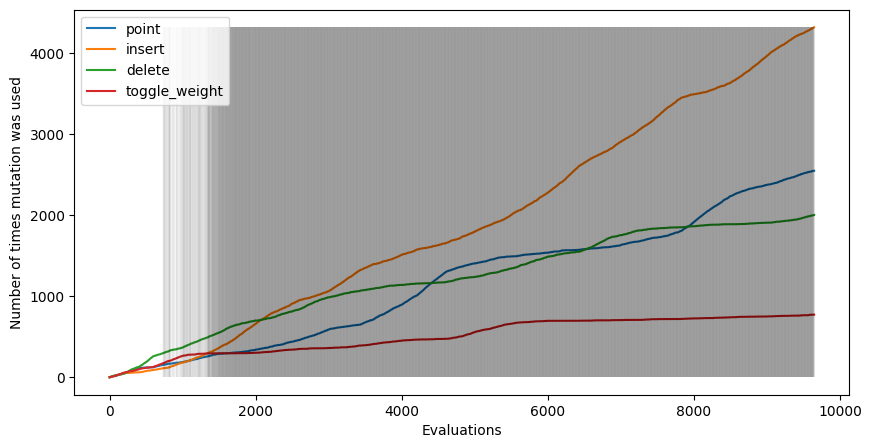

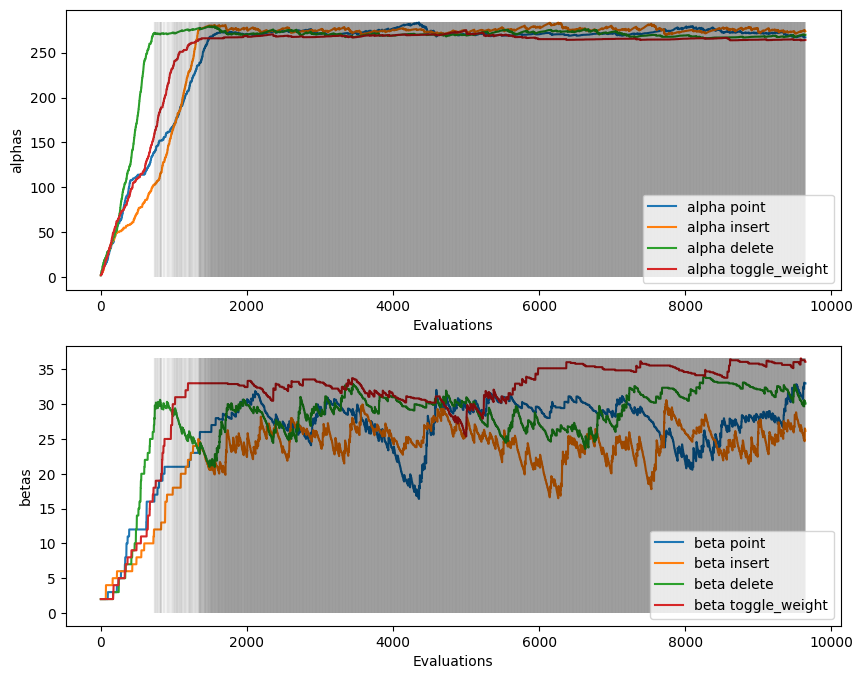

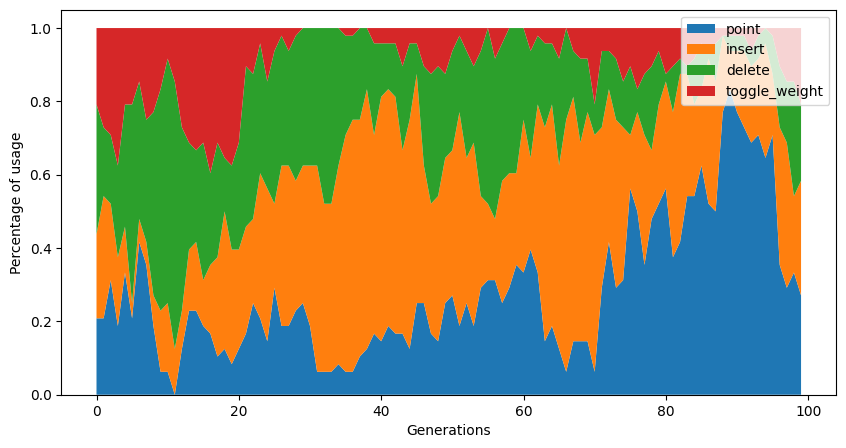

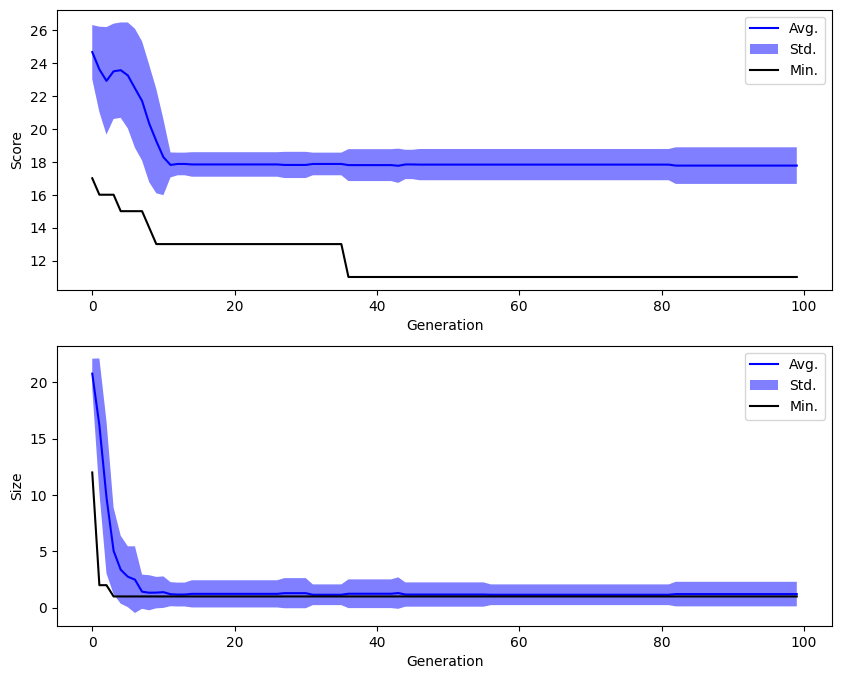

In [7]:
generate_plots()